In [3]:
import pandas as pd
import numpy as np 
import requests
import json
import time
import configparser
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
#import datetime as dt
from datetime import datetime, timedelta
from strava_helper_functions import seconds_to_duration, calculate_pace

In [2]:
# Read the config file
config = configparser.ConfigParser()
config.read('tokens/config.ini')

## Get the tokens from file to connect to Strava
with open('tokens/strava_tokens.json') as json_file:
    strava_tokens = json.load(json_file)

## If access_token has expired then use the refresh_token to get the new access_token
if strava_tokens['expires_at'] < time.time():
    
    #Make Strava auth API call with current refresh token
    response = requests.post(
                        url = 'https://www.strava.com/oauth/token',
                        data = {
                                'client_id': int(config['STRAVA_TOKENS']['client_id']),
                                'client_secret': config['STRAVA_TOKENS']['client_secret'],
                                'grant_type': 'refresh_token',
                                'refresh_token': strava_tokens['refresh_token']
                                }
                    )
    
    # Save response as json in new variable
    new_strava_tokens = response.json()
    
    # Save new tokens to file
    with open('strava_tokens.json', 'w') as outfile:
        json.dump(new_strava_tokens, outfile)
    
    #Use new Strava tokens from now
    strava_tokens = new_strava_tokens

#Loop through all activities
page = 1
url = "https://www.strava.com/api/v3/activities"
access_token = strava_tokens['access_token']

# Create the dataframe ready for the API call to store your activity data
activities = pd.DataFrame(
    columns = [
            "name",
            "start_date_local",
            "type",
            "distance",
            "moving_time",
            "elapsed_time",
            "total_elevation_gain",
            "average_heartrate",
            "max_heartrate",
            "average_speed"

    ]
)

while True:
    
    # Get page of activities from Strava
    r = requests.get(url + '?access_token=' + access_token + '&per_page=200' + '&page=' + str(page))
    r = r.json()
    
    # If no results then exit loop
    if (not r):
        break
    
    # Otherwise add new data to dataframe
    for x in range(len(r)):
        activities.loc[x + (page-1)*200,'name'] = r[x]['name']
        activities.loc[x + (page-1)*200,'start_date_local'] = r[x]['start_date_local']
        activities.loc[x + (page-1)*200,'type'] = r[x]['type']
        activities.loc[x + (page-1)*200,'distance'] = r[x]['distance']
        activities.loc[x + (page-1)*200,'moving_time'] = r[x]['moving_time']
        activities.loc[x + (page-1)*200,'elapsed_time'] = r[x]['elapsed_time']
        activities.loc[x + (page-1)*200,'total_elevation_gain'] = r[x]['total_elevation_gain']
        # Check if heartrate is in the activity. If so, pull into dataframe
        if "average_heartrate" in r[x]: 
            activities.loc[x + (page-1)*200,'average_heartrate'] = r[x]['average_heartrate']
            activities.loc[x + (page-1)*200,'max_heartrate'] = r[x]['max_heartrate']
        # Check if speed is in the activity. If so, pull the avg speed
        if "average_speed" in r[x]:
            activities.loc[x + (page-1)*200,'average_speed'] = r[x]['average_speed']
    
    # increment page
    page += 1

# dump to a .csv
activities.to_csv('data/strava_activities_raw.csv',index=False)

In [9]:
# Clean up dataframe
actv = pd.read_csv('data/strava_activities_raw.csv')
actv.rename(columns={'distance':'distance_meters'
                    ,'moving_time':'moving_time_sec'
                    ,'total_elevation_gain':'elevation_gain_m'},inplace=True)
actv['start_time'] = pd.to_datetime(actv.start_date_local).dt.time
actv['start_date'] = pd.to_datetime(actv.start_date_local).dt.date
actv['day_of_week_no'] = pd.to_datetime(actv.start_date_local).dt.weekday
actv['day_of_week'] = pd.to_datetime(actv.start_date_local).dt.weekday_name
actv['week_start'] = actv.apply(lambda x: x.start_date - timedelta(days=x.start_date.weekday()),axis=1)
actv['distance_miles'] = round(actv.distance_meters / 1609,4)
actv['elevation_gain_ft'] = round(actv.elevation_gain_m * 3.28084,2)
actv['moving_time'] = actv.apply(lambda x: seconds_to_duration(x['moving_time_sec']),axis=1) #Converts moving_time (in seconds) to a duration
actv['elapsed_time'] = actv.apply(lambda x: seconds_to_duration(x['elapsed_time']),axis=1) #Converts elapsed_time (in seconds) to duration
actv['running_pace'] = actv.apply(lambda x: np.where(x['type'] == 'Run', calculate_pace(x.distance_miles, x.moving_time), ''),axis=1)
actv['avg_speed_mph'] = round(actv.average_speed * 2.23694,2)
        
actv.to_csv('data/strava_activities.csv',index=False)

In [17]:
# make subset of actv for only running data

remove_these_runs = list({'2019-01-24T14:37:30Z'}) #,'2021-02-18T17:55:15Z'})

run_actv = actv[(actv.type == 'Run') 
               # & (actv.avg_speed_mph > 7.15)
                & ~(actv.start_date_local.isin(remove_these_runs))
                & (actv.start_date_local > '2020-01-01')
                ]

run_hist = pd.pivot_table(run_actv
            , index = 'week_start'
            , columns = ['day_of_week_no','day_of_week']
            , values = 'distance_miles'
            , aggfunc = 'sum').reset_index().fillna(0)

# Group by week start and average speed
gp_week_st = (run_actv.groupby('week_start').agg('mean').reset_index()).rename(columns={'avg_speed_mph':'weekly_avg_speed_mph'})

# Add back to run_actv with new weekly average
run_actv = pd.merge(left = run_actv, right= gp_week_st[['week_start','weekly_avg_speed_mph']]
        , how='left', on = 'week_start') 

In [18]:
columns = ['week_start','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

run_hist.columns = columns
run_hist['weekly_mileage'] = run_hist.iloc[:, 1:].sum(axis=1)
run_hist

,week_start,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,weekly_mileage
0,2020-05-18,0.0000,0.0000,0.0000,0.0000,5.0938,0.0000,7.1386,12.2324
1,2020-05-25,0.0000,4.0584,4.3170,5.0727,0.0000,10.1201,6.0211,29.5893
2,2020-06-01,3.0267,4.0705,6.0211,4.2119,0.0000,12.0520,4.0696,33.4518
3,2020-06-08,4.7520,8.0245,5.1073,4.0897,4.3351,15.2903,0.0000,41.5989
4,2020-06-15,5.0549,9.1154,4.8799,5.0454,5.1626,17.4400,0.0000,46.6982
5,2020-06-22,5.2076,8.1001,3.8533,6.0547,5.5911,18.6165,0.0000,47.4233
6,2020-06-29,6.1641,8.4661,0.0000,6.6853,0.0000,0.0000,20.0521,41.3676
7,2020-07-06,0.0000,7.8285,6.2324,5.8297,5.0553,0.0000,9.2200,34.1659
8,2020-07-13,2.0311,7.6967,4.5221,6.9030,0.0000,19.2592,0.0000,40.4121
9,2020-07-20,6.0292,8.2610,6.0733,5.6246,2.4984,17.3045,0.0000,45.7910


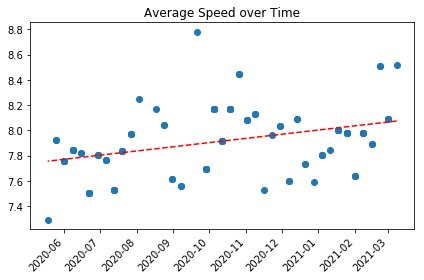

In [31]:
# Create chart for speed over time
fig = plt.figure() #create overall container
ax1 = fig.add_subplot(111) #add a 1 by 1 plot to the figure
x = np.asarray(run_actv.week_start)  #convert data to numpy array
y = np.asarray(run_actv.weekly_avg_speed_mph)
ax1.plot_date(x, y) #plot data points in scatter plot on ax1
ax1.set_title('Average Speed over Time')
#add trend line
x2 = mdates.date2num(x)
z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')
#format the figure and display
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

count    113.000000
mean       7.082102
std        4.062626
min        1.079600
25%        4.380400
50%        6.232400
75%        8.024500
max       26.217500
Name: distance_miles, dtype: float64

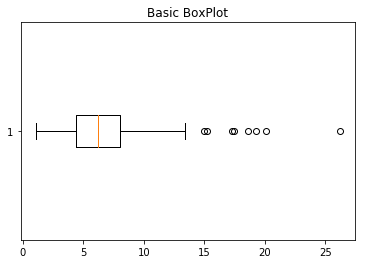

In [45]:
# Look at the spread of distance run

fig1, ax1 = plt.subplots()
ax1.boxplot(run_actv.distance_miles, vert=False)

run_actv.distance_miles.describe()